In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [28]:

# Data Retrieval and Preparation
# Load STRIPS data
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

# Extract unique maturities from column names
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
print("Maturities:", maturities)

# Select a date (closest to March 14, 2025; using February 04, 2025 as specified)
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]

# Extract times and prices for the selected date
times = [data_on_date[f'Time_{mat}'].values[0] for mat in maturities]
yields = [data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]
strips_prices = [data_on_date[f'Price_{mat}'].values[0] for mat in maturities]

# Convert to numpy arrays and filter out NaN values
times = np.array(times)
yields = np.array(yields) * 100  # Convert to percentage (e.g., 0.04368 -> 4.368)
strips_prices = np.array(strips_prices)
valid_idx = ~np.isnan(times) & ~np.isnan(yields) & ~np.isnan(strips_prices)
times = times[valid_idx]
yields = yields[valid_idx]
strips_prices = strips_prices[valid_idx]

print(f"Data for {dt}:")
print("Times (years):", times)
print("Yields (%):", yields)
print("STRIPS Prices ($):", strips_prices)


Maturities: ['Aug2025', 'Aug2026', 'Aug2027', 'Aug2028', 'Aug2029', 'Aug2030', 'Aug2031', 'Aug2032', 'Aug2033', 'Aug2034', 'Aug2039', 'Feb2025', 'Feb2026', 'Feb2027', 'Feb2028', 'Feb2029', 'Feb2031', 'Feb2032', 'Feb2033', 'Feb2034', 'Feb2036', 'Feb2037', 'Feb2038', 'Feb2039', 'May2025', 'May2026', 'May2027', 'May2028', 'May2029', 'May2030', 'May2031', 'May2032', 'May2033', 'May2034', 'May2037', 'May2038', 'May2039', 'Nov2025', 'Nov2026', 'Nov2027', 'Nov2028', 'Nov2030', 'Nov2031', 'Nov2032', 'Nov2033', 'Nov2034']
Data for 2025-02-04:
Times (years): [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.272

In [29]:

# Two-Factor Vasicek Model Definition
class Two_Factor_Vasicek_Model:
    def __init__(self, x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2):
        self.x1_0 = x1_0  # Initial value of x1
        self.x2_0 = x2_0  # Initial value of x2
        self.mu1 = mu1    # Long-term mean of x1
        self.mu2 = mu2    # Long-term mean of x2
        self.vol1 = vol1  # Volatility of x1
        self.vol2 = vol2  # Volatility of x2
        self.var1 = vol1 * vol1  # Variance of x1
        self.var2 = vol2 * vol2  # Variance of x2
        self.kappa1 = kappa1  # Mean reversion speed of x1
        self.kappa2 = kappa2  # Mean reversion speed of x2
    
    def mean_r(self, t, dist='Q'):
        # Expected short rate: E[r(t)] = E[x1(t)] + E[x2(t)]
        m1 = np.exp(-self.kappa1 * t) * self.x1_0 + self.mu1 / self.kappa1 * (1 - np.exp(-self.kappa1 * t))
        m2 = np.exp(-self.kappa2 * t) * self.x2_0 + self.mu2 / self.kappa2 * (1 - np.exp(-self.kappa2 * t))
        return m1 + m2
    
    def B(self, tau, kappa):
        # B function for a given factor and maturity
        return (1 - np.exp(-kappa * tau)) / kappa
    
    def A(self, tau):
        # A function as the sum of contributions from both factors
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        term1 = (self.mu1 / self.kappa1 - self.var1 / (2 * self.kappa1**2)) * (B1 - tau) - self.var1 * B1**2 / (4 * self.kappa1)
        term2 = (self.mu2 / self.kappa2 - self.var2 / (2 * self.kappa2**2)) * (B2 - tau) - self.var2 * B2**2 / (4 * self.kappa2)
        return term1 + term2

    def zero(self, t0, T, x1_t0=None, x2_t0=None):
        if x1_t0 is None:
            x1_t0 = self.x1_0
        if x2_t0 is None:
            x2_t0 = self.x2_0
        tau = T - t0
        if tau <= 0:
            return 1.0
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        price = np.exp(self.A(tau) - B1 * x1_t0 - B2 * x2_t0)
        return max(price, 1e-10)  # Clamp to a small positive value to avoid log(0)
    
    def yield_curve(self, tau):
        # Yield for maturity tau: Y(tau) = -ln(P(0, tau)) / tau
        if tau <= 0:
            return np.nan  # Avoid division by zero
        p = self.zero(0, tau)
        return -np.log(p) / tau * 100  # In percentage
    
    def update_params(self, x):
        self.x1_0 = max(x[0], 0)  # Ensure x1_0 is non-negative
        self.x2_0 = max(x[1], 0)  # Ensure x2_0 is non-negative
        self.mu1 = x[2]
        self.mu2 = x[3]
        self.vol1 = max(x[4], 1e-6)  # Ensure vol1 is positive
        self.vol2 = max(x[5], 1e-6)  # Ensure vol2 is positive
        self.var1 = pow(self.vol1, 2)
        self.var2 = pow(self.vol2, 2)
        self.kappa1 = max(x[6], 1e-6)  # Ensure kappa1 is positive
        self.kappa2 = max(x[7], 1e-6)  # Ensure kappa2 is positive


In [30]:

# Calibrate Two-Factor Vasicek Model
def compute_bond_prices_with_coupons(model, maturities, face_value=100, coupon_rate=0.0, frequency=2):
    prices = np.zeros(len(maturities))
    for i, tau in enumerate(maturities):
        principal_price = model.zero(0, tau) * face_value
        if coupon_rate > 0 and tau >= 1 / frequency:
            coupon_payment = (coupon_rate / frequency) * face_value
            num_coupons = int(tau * frequency)
            coupon_times = np.linspace(1 / frequency, tau, num_coupons)
            discounts = np.array([model.zero(0, t) for t in coupon_times])
            coupon_price = np.sum(discounts * coupon_payment)
        else:
            coupon_price = 0
        prices[i] = coupon_price + principal_price
    return prices

# Objective function for calibration
def objective_function(params, model, maturities, market_prices, face_value):
    model.update_params(params)
    model_prices = compute_bond_prices_with_coupons(model, maturities, face_value, 0.0, 2)
    return np.sum((model_prices - market_prices) ** 2)

# Initial parameters (guesses)
x1_0 = 0.02  # Initial value of x1 (2%)
x2_0 = 0.02  # Initial value of x2 (2%)
mu1 = 0.01   # Long-term mean of x1 (1%)
mu2 = 0.01   # Long-term mean of x2 (1%)
vol1 = 0.05  # Volatility of x1
vol2 = 0.05  # Volatility of x2
kappa1 = 0.2 # Mean reversion speed of x1
kappa2 = 0.1 # Mean reversion speed of x2 (slower to capture longer-term dynamics)

# Initialize the model
model = Two_Factor_Vasicek_Model(x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2)

# Initial parameter vector
initial_params = [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]

# Bounds for parameters
bounds = [
    (0, 0.1),  # x1_0
    (0, 0.1),  # x2_0
    (-0.1, 0.1),  # mu1
    (-0.1, 0.1),  # mu2
    (1e-6, 0.2),  # vol1
    (1e-6, 0.2),  # vol2
    (1e-6, 1.0),  # kappa1
    (1e-6, 1.0)   # kappa2
]

# Calibrate the model
face_value = 100
result = minimize(
    objective_function,
    initial_params,
    args=(model, times, strips_prices, face_value),
    method='Nelder-Mead',
    bounds=bounds,
    options={'disp': True, 'maxiter': 1000}
)

# Update model with calibrated parameters
calibrated_params = result.x
model.update_params(calibrated_params)

print("Calibrated Two-Factor Vasicek Parameters:")
print(f"x1_0: {calibrated_params[0]:.4f}")
print(f"x2_0: {calibrated_params[1]:.4f}")
print(f"mu1: {calibrated_params[2]:.4f}")
print(f"mu2: {calibrated_params[3]:.4f}")
print(f"vol1: {calibrated_params[4]:.4f}")
print(f"vol2: {calibrated_params[5]:.4f}")
print(f"kappa1: {calibrated_params[6]:.4f}")
print(f"kappa2: {calibrated_params[7]:.4f}")


Optimization terminated successfully.
         Current function value: 2.804065
         Iterations: 213
         Function evaluations: 342
Calibrated Two-Factor Vasicek Parameters:
x1_0: 0.0125
x2_0: 0.0253
mu1: 0.0056
mu2: 0.0076
vol1: 0.0539
vol2: 0.0193
kappa1: 0.3745
kappa2: 0.1388


In [31]:

# Load Bond Data
csv_file_path = "/Users/dr/Documents/GitHub/FixedIncome/bond data for pricing analysis.csv"
bond_df = pd.read_csv(csv_file_path)

# Filter and retain only the necessary columns
bond_data = bond_df[['Security', 'Maturity', 'Coupon Rate', 'Price', 'Coupon Frequency']].copy()
bond_data['Coupon Rate'] = bond_data['Coupon Rate'] / 100
print("\nBond Data:")
print(bond_data)



Bond Data:
              Security  Maturity  Coupon Rate       Price  Coupon Frequency
0          3-mo T-bill      0.25      0.00000   95.810000                 1
1   10yr Treasury Bond      9.88      0.04625  104.750000                 2
2    5yr Treasury Bond      4.99      0.04000  101.167969                 2
3    2yr Treasury Bond      2.66      0.00625   92.320312                 2
4             2yr TIPS      3.54      0.02375  104.843750                 2
5    Corporate Bond(A)      7.12      0.05125  101.677000                 2
6    Corporate Bond(B)      4.66      0.08875   62.076000                 2
7  Corporate Bond(BBB)     10.00      0.05500  100.433000                 2


In [32]:

# Compute Prices with Calibrated Model
# STRIPS prices
zero_coupon_prices = compute_bond_prices_with_coupons(model, times, face_value, 0.0, 2)

# Bond prices
bond_model_prices = {}
for _, row in bond_data.iterrows():
    security = row['Security']
    coupon_rate = row['Coupon Rate']
    frequency = row['Coupon Frequency']
    bond_maturities = np.array([row['Maturity']])  # Single maturity for each bond
    bond_model_prices[security] = compute_bond_prices_with_coupons(model, bond_maturities, face_value, coupon_rate, frequency)[0]


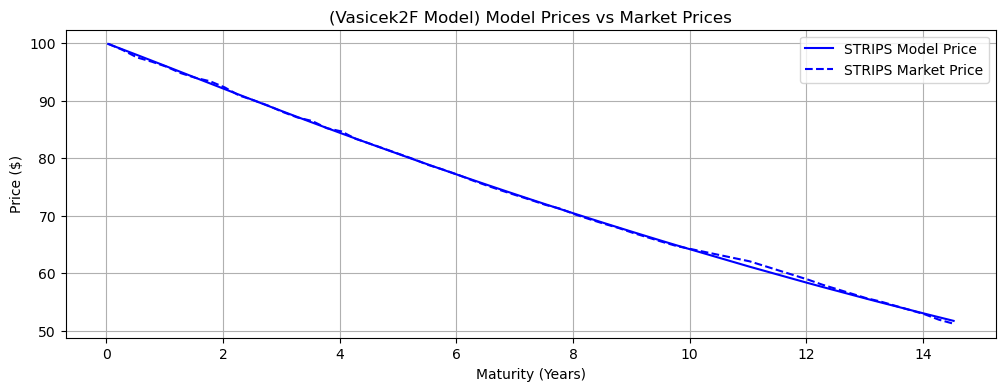

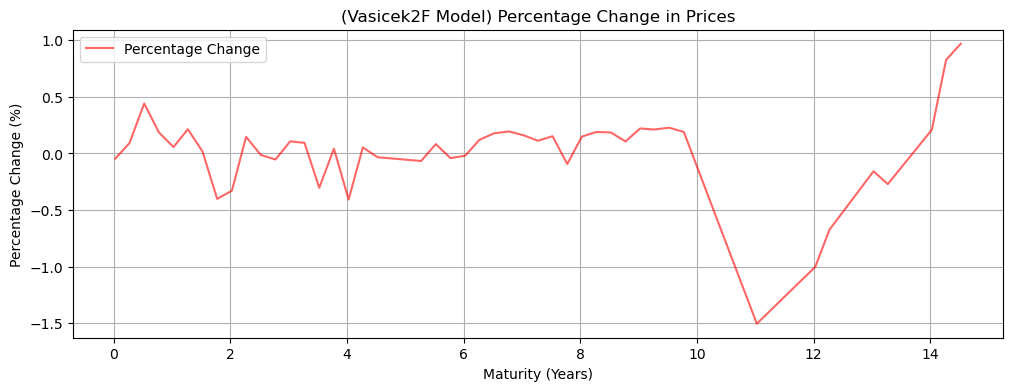

In [39]:
# Calculate percentage change in prices
percentage_change = ((zero_coupon_prices - strips_prices) / strips_prices) * 100

# Sort the data by maturity (times) to ensure smooth plotting
sorted_indices = np.argsort(times)
sorted_times = times[sorted_indices]
sorted_zero_coupon_prices = zero_coupon_prices[sorted_indices]
sorted_strips_prices = strips_prices[sorted_indices]
sorted_percentage_change = percentage_change[sorted_indices]

# Plot original graph (Model Prices vs Market Prices)
plt.figure(figsize=(12, 4))
plt.plot(sorted_times, sorted_zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(sorted_times, sorted_strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)
plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('(Vasicek2F Model) Model Prices vs Market Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot percentage change graph
plt.figure(figsize=(12, 4))
# Using scatter plot for percentage change to avoid "scratched" appearance
plt.plot(sorted_times, sorted_percentage_change, color='red', linestyle='-', label='Percentage Change', alpha=0.6)
plt.xlabel('Maturity (Years)')
plt.ylabel('Percentage Change (%)')
plt.title('(Vasicek2F Model) Percentage Change in Prices')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_73770/450895232.py:13: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([maturity], [market_price], color=colors[i], label=f'{security} Market', marker='x', s=100, edgecolors='black')


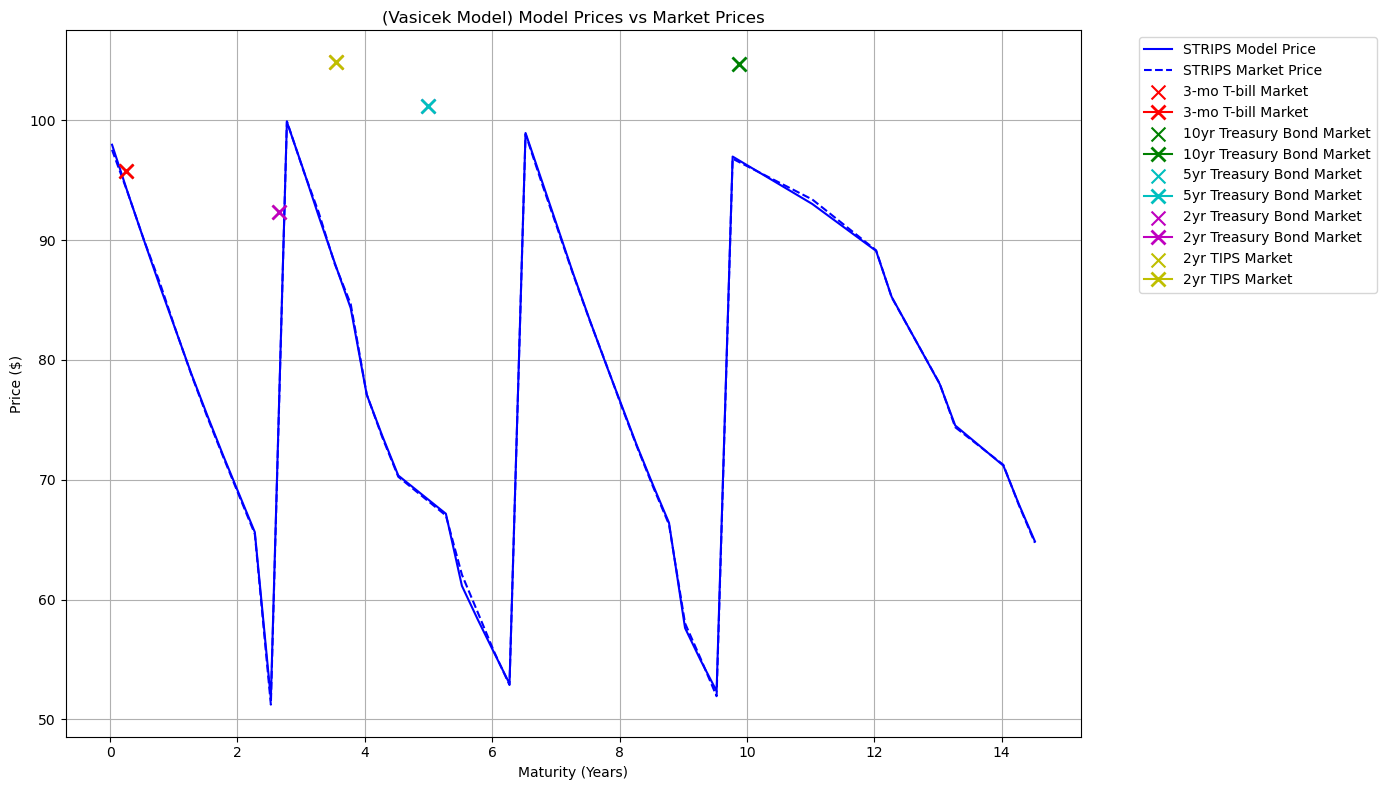

In [49]:
# Plotting
plt.figure(figsize=(14, 8))

# STRIPS
plt.plot(sorted_times, zero_coupon_prices, 'b-', label='STRIPS Model Price', linewidth=1.5)
plt.plot(sorted_times, strips_prices, 'b--', label='STRIPS Market Price', linewidth=1.5)

# Bonds
colors = ['r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple']
for i, (security, prices) in enumerate(bond_model_prices.items()):
    if i < 5:  # Plot only bonds with index less than 5
        # Plot model prices
        plt.scatter([maturity], [market_price], color=colors[i], label=f'{security} Market', marker='x', s=100, edgecolors='black')
        
        # Plot market price at the bond's maturity
        maturity = bond_data.loc[bond_data['Security'] == security, 'Maturity'].values[0]
        market_price = bond_data.loc[bond_data['Security'] == security, 'Price'].values[0]
        plt.plot(maturity, market_price, marker='x', color=colors[i], markersize=10, markeredgewidth=2, label=f'{security} Market')

# Labels and title
plt.xlabel('Maturity (Years)')
plt.ylabel('Price ($)')
plt.title('(Vasicek Model) Model Prices vs Market Prices')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()